In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:
# Calculate pairwise squared Euclidean distance
def calc_distance(X, Z):
    return tf.reduce_sum(
        (tf.expand_dims(X, 2) - 
         tf.expand_dims(tf.transpose(Z), 0))**2, 1)

# Return 
def find_kNN(Distance, K):
    numTrainData = tf.shape(Distance)[1]
    distance_k, index_k = tf.nn.top_k(-Distance, k = K)
    R = tf.reduce_sum(tf.to_float(
            tf.equal(tf.expand_dims(index_k, 2), 
                     tf.reshape(tf.range(numTrainData), [1, 1, -1]))
        ), 1)
    return R / tf.to_float(K)

In [15]:
def run_kNN(R, trainY):
    return tf.matmul(R, trainY)

In [16]:
def softKNearest(Distance, trainY):
    return tf.matmul(tf.nn.softmax(-Distance / 2.), trainY)

def expKernelGP(DistancexX, DistanceXX, trainY, _lambda):
    sigma_obsv = 0. #observation noise 
    gram = tf.exp(-DistanceXX * _lambda) + sigma_obsv * tf.diag(tf.ones((tf.shape(DistanceXX)[0], )))
    weight = tf.matmul(tf.exp(-DistancexX * _lambda), tf.matrix_inverse(gram))
    predY = tf.matmul(weight, trainY)
    return predY

K = 1    Validation MSE = 0.386936, Test MSE = 0.465726


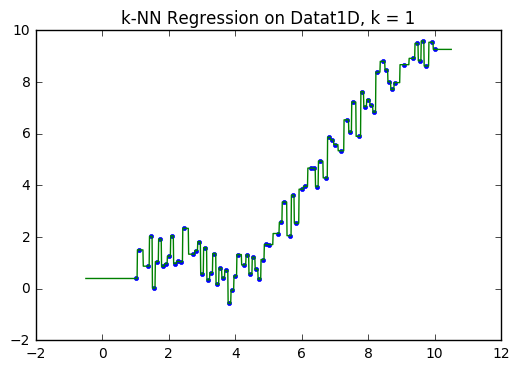

K = 3    Validation MSE = 0.174302, Test MSE = 0.679265


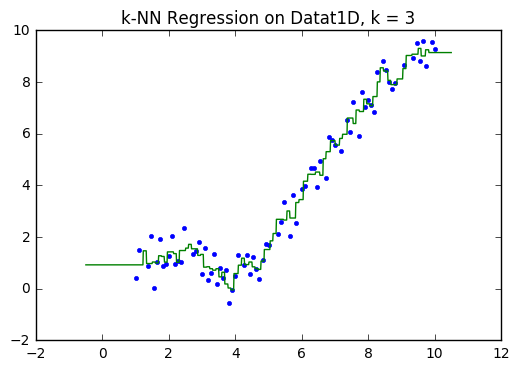

K = 5    Validation MSE = 0.176288, Test MSE = 0.477243


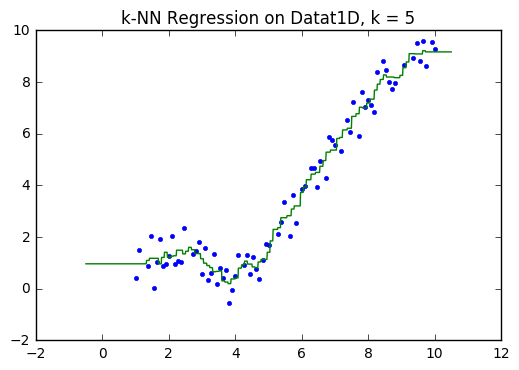

K = 10    Validation MSE = 0.174439, Test MSE = 0.501937


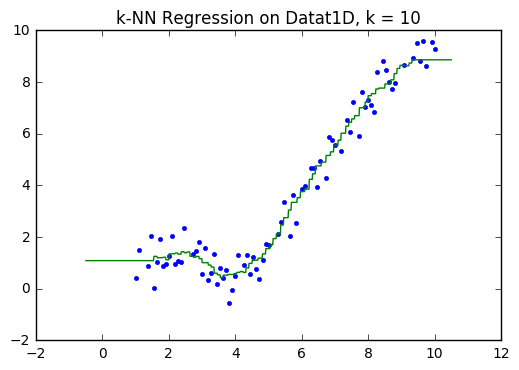

K = 25    Validation MSE = 0.312942, Test MSE = 0.790343


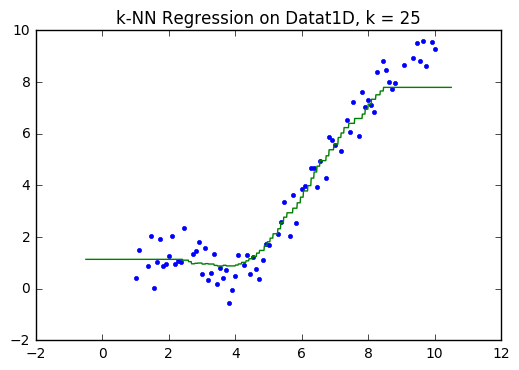

K = 50    Validation MSE = 3.242872, Test MSE = 4.053578


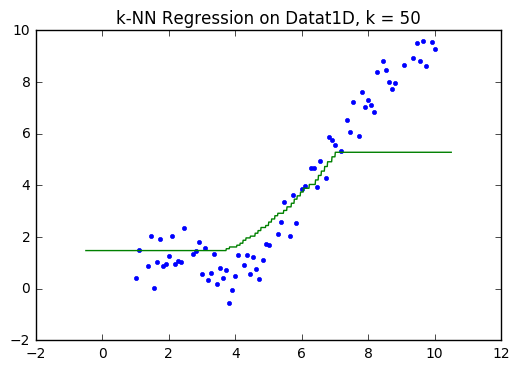

Best K using validation set is K = 3


In [17]:
if __name__ == '__main__':
    
    # Generate test data
    # Change seed and index as you wish
    np.random.seed(123)
    Data = np.linspace(1.0 , 10.0 , num = 100) [:, np.newaxis]
    # T = sin(D) + (0.1 * D^2) + rand()
    Target = np.sin( Data ) + 0.1 * np.power( Data , 2) + 0.5 * np.random.randn(100 , 1)
    rand_index = np.arange(100)
    np.random.shuffle(rand_index)
    train_data = Data[rand_index[:80]]
    train_target = Target[rand_index[:80]]
    valid_data = Data[rand_index[80:90]]
    valid_target = Target[rand_index[80:90]]
    test_data = Data[rand_index[90:100]]
    test_target = Target[rand_index[90:100]]

    # Build graph
    trainX = tf.placeholder(tf.float32, [None, 1], name = 'input_x')
    trainY = tf.placeholder(tf.float32, [None, 1], name = 'input_y')
    newX = tf.placeholder(tf.float32, [None, 1], name = 'new_x')
    newY = tf.placeholder(tf.float32, [None, 1], name = 'new_y')
    K = tf.placeholder("int32", name = 'K')
    predY = run_kNN(find_kNN(calc_distance(newX, trainX), K = K), trainY)
    MSE = tf.reduce_mean(tf.reduce_sum((predY - newY)**2, 1))
    sess = tf.InteractiveSession()

    # Run & Plot
    X = np.linspace(-0.5, 10.5, num = 1000)[:, np.newaxis]
    k_list = [1, 3, 5, 10, 25, 50] # Add any k of interest
    mse_valid_list = []
    mse_test_list = []
    for kc in k_list:
        mse_valid = sess.run(MSE, feed_dict =
                             {trainX:train_data, trainY:train_target, 
                              newX:valid_data, newY:valid_target, 
                              K:kc})
        mse_test = sess.run(MSE, feed_dict =
                            {trainX:train_data, trainY:train_target, 
                             newX:test_data, newY:test_target, 
                             K:kc})
        mse_valid_list.append(mse_valid)
        mse_test_list.append(mse_test)
        print("K = %d    Validation MSE = %f, Test MSE = %f" %(kc, mse_valid, mse_test))
        yp = sess.run(predY, feed_dict = {trainX:train_data, trainY:train_target, newX:X, K:kc})
        plt.figure(kc + 1)
        plt.plot(train_data, train_target, '.')
        plt.plot(X, yp, '-')
        plt.title("k-NN Regression on Datat1D, k = %d" %kc)
        plt.show()
    k_best = k_list[np.argmin(mse_valid_list)]
    print("Best K using validation set is K = %d" %(k_best))